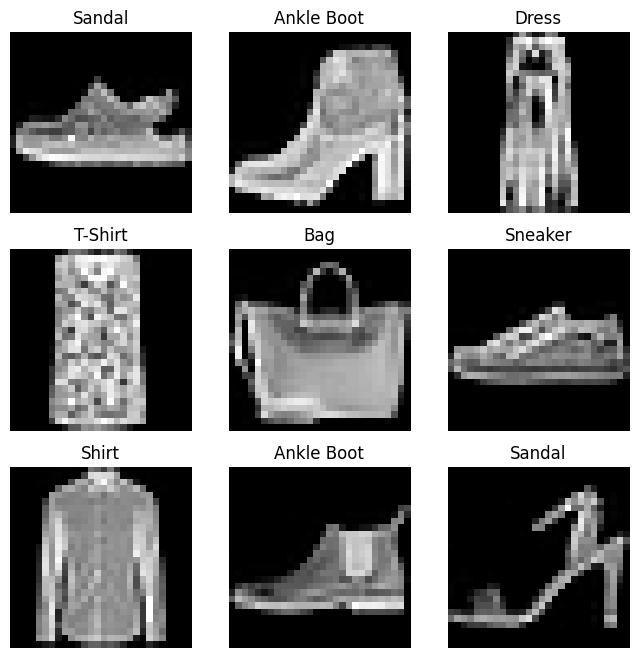

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision import transforms

PATH = 'fashion-mnist/data'

transform = transforms.Compose([transforms.ToTensor()])

train_data = datasets.FashionMNIST(
    root=PATH,
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.FashionMNIST(
    root=PATH,
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(
    train_data,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    test_data,
    batch_size=64,
    shuffle=False
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), ceil_mode=True),
            nn.Conv2d(16, 8, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), ceil_mode=True),
            nn.Conv2d(8, 8, (3,3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d((2,2), ceil_mode=True)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(8, 8, (3,3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(8, 8, (3,3), padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(8, 16, (3,3)),
            nn.ReLU(),
            nn.Upsample(scale_factor=(2,2)),
            nn.Conv2d(16, 1, (3,3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
net = AE()
if torch.cuda.is_available():
    net.cuda()
summary(net, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]           1,160
              ReLU-5            [-1, 8, 14, 14]               0
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7              [-1, 8, 7, 7]             584
              ReLU-8              [-1, 8, 7, 7]               0
         MaxPool2d-9              [-1, 8, 4, 4]               0
           Conv2d-10              [-1, 8, 4, 4]             584
             ReLU-11              [-1, 8, 4, 4]               0
         Upsample-12              [-1, 8, 8, 8]               0
           Conv2d-13              [-1, 8, 8, 8]             584
             ReLU-14              [-1, 

In [7]:
import torch.optim as optim

loss_fn = nn.MSELoss()
optimizer = optim.Adam(net.parameters())
losses = []

def train_one_epoch(epoch_index, tb_writer, device):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(train_loader):
        inputs= data[0].to(device)
        # inputs = inputs.reshape(-1, 28*28)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_fn(outputs, inputs)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

cuda:0
EPOCH 1:
  batch 100 loss: 0.09747079186141491
  batch 200 loss: 0.03450971726328134
  batch 300 loss: 0.029037443827837704
  batch 400 loss: 0.026889150720089672
  batch 500 loss: 0.02536305632442236
  batch 600 loss: 0.02386954231187701
  batch 700 loss: 0.023028624020516874
  batch 800 loss: 0.022285585477948188
  batch 900 loss: 0.021669688634574413
LOSS train 0.021669688634574413 valid 0.02123967371881008
EPOCH 2:
  batch 100 loss: 0.021099080312997103
  batch 200 loss: 0.020548107475042342
  batch 300 loss: 0.02015505760908127
  batch 400 loss: 0.01975211502984166
  batch 500 loss: 0.019644009973853828
  batch 600 loss: 0.01921425459906459
  batch 700 loss: 0.019067535027861595
  batch 800 loss: 0.018872437048703432
  batch 900 loss: 0.01845365095883608
LOSS train 0.01845365095883608 valid 0.01854194514453411
EPOCH 3:
  batch 100 loss: 0.018254574090242386
  batch 200 loss: 0.01808259087614715
  batch 300 loss: 0.01810777681879699
  batch 400 loss: 0.01780871598981321
  ba

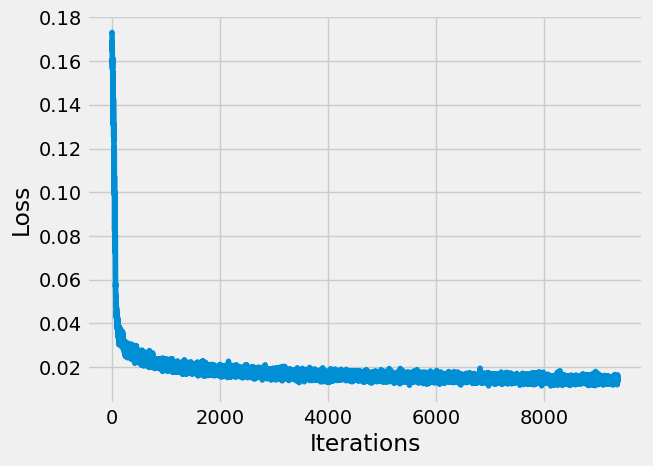

In [8]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))

epoch_number = 0
epochs = 10
best_vloss = 1_000_000.

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
net.to(device)

for epoch in range(epochs):
    print('EPOCH {}:'.format(epoch_number + 1))

    net.train(True)
    avg_loss = train_one_epoch(epoch_number, writer, device)

    running_vloss = 0.0
    net.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs = vdata[0].to(device)
            # vinputs = vinputs.reshape(-1, 28*28)

            voutputs = net(vinputs)
            vloss = loss_fn(voutputs, vinputs)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './model/ae_model_{}_{}'.format(timestamp, epoch_number)
        torch.save(net.state_dict(), model_path)

    epoch_number += 1

# Defining the Plot Style
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')
# Plotting the last 100 values
plt.plot(losses[0:])

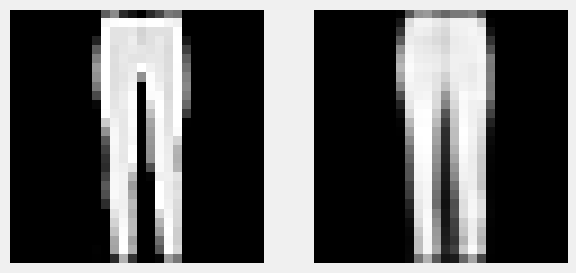

In [9]:
net.eval()

sample_idx = torch.randint(len(train_data), size=(1,)).item()
img, _ = train_data[sample_idx]
input = img.reshape(1,1,28,28)

reconstructed = net(input.to(device)).detach().cpu().numpy()
# reconstructed = reconstructed.reshape(28,28)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.axis("off")
plt.imshow(img.squeeze(), cmap='gray')
fig.add_subplot(1,2,2)
plt.axis("off")
plt.imshow(reconstructed.squeeze(), cmap='gray')
plt.show()